# 1. Подготовка

In [77]:
import pandas as pd

In [78]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [79]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Количество заказов находится в столбце 'num_orders'

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


# 2. Анализ

In [81]:
df.sort_index(inplace=True)


In [82]:
#Узнаем весь промежуток времени заказов такси
print(df.index)

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)


In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

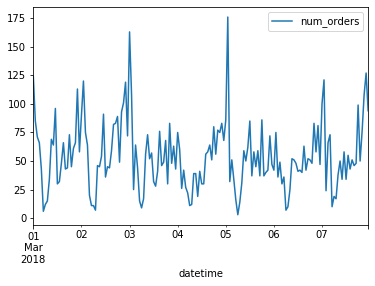

In [85]:
df_H = df['2018-03-01':'2018-03-07'].resample('1H').sum()
#df_H['rolling_mean'] = df.rolling(10).mean()
df_H.plot()

Мы отчетливо видим снижение заказов в неделю. 3 марта 18 года это суббота и 5 марта понедельник. Все заказы около 12 ночи так что основной трафик это ночь перед выходными и ночь после. 

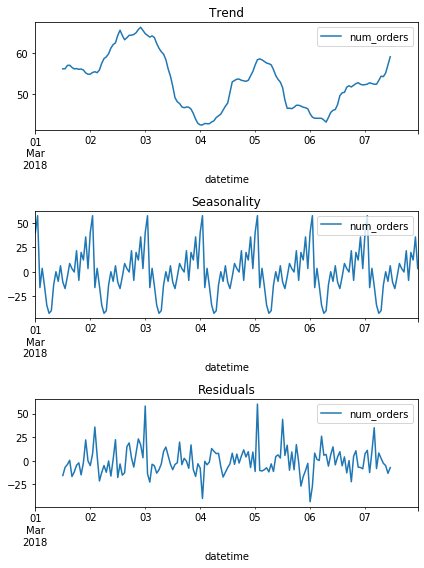

In [86]:
decomposed = seasonal_decompose(df_H)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Сезонный график нам поможет определить время пиковых загрузок. С утра оно начинает расти и уже к 12 ночи доходит до своего пика, а затаем падает.

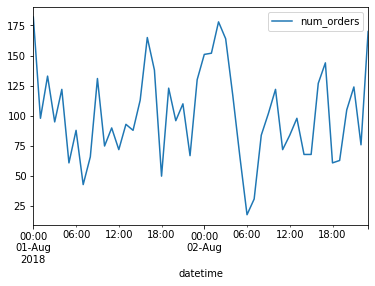

In [87]:
df_HA = df['2018-08-01':'2018-08-02'].resample('1H').sum()
#df['rolling_mean'] = df.rolling(10).mean()
df_HA.plot()

На Августовском графике мы четко видим, как формируются запросы на такси в течении дня. Виден пик на 16-17 часах. 

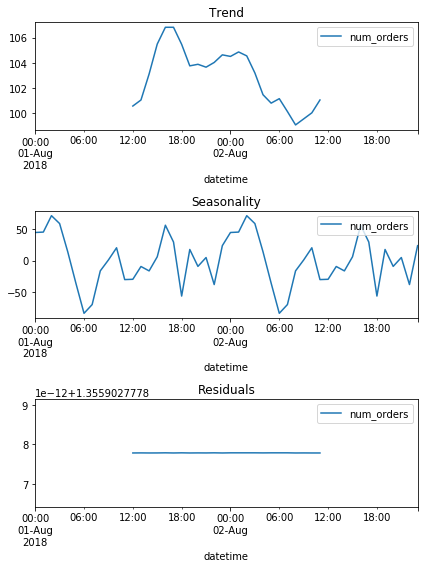

In [88]:
decomposed = seasonal_decompose(df_HA)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

# 3. Обучение

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from  sklearn.ensemble import RandomForestRegressor

In [90]:
#Cоздаем признаки.
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['second'] = df.index.second
    df['day'] = df.index.day
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

<b>LinearRegression

In [68]:
def model_LR(df, model):    # Создадим цикл для подбора лучших параметров. 
    for max_lag in range(1, 10):
        for rolling_mean_size in range (1, 10):
            make_features(df, max_lag, rolling_mean_size)

            df = df.dropna()

            df_train, df_test = train_test_split(df, test_size=0.1, random_state=12345)
            df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=12345)

            features_test = df_test.drop(['num_orders'], axis=1)
            target_test = df_test['num_orders']

            features_train = df_train.drop(['num_orders'], axis=1)
            target_train = df_train['num_orders']

            features_valid = df_valid.drop(['num_orders'], axis=1)
            target_valid = df_valid['num_orders']

            model = model
            modelLR.fit(features_train, target_train)

            predictLR = modelLR.predict(features_valid)

            print("RMSE тестовой выборки: ", mean_squared_error(target_valid, predictLR)**0.5)
            print("max_lag =", max_lag, "rolling_mean_size =", rolling_mean_size, end='') 

In [69]:
model_LR(df,  LinearRegression())

RMSE тестовой выборки:  7.057663917155215
max_lag = 1 rolling_mean_size = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

RMSE тестовой выборки:  7.037813289337565
max_lag = 1 rolling_mean_size = 2RMSE тестовой выборки:  7.028333984769
max_lag = 1 rolling_mean_size = 3RMSE тестовой выборки:  7.004157263616354
max_lag = 1 rolling_mean_size = 4RMSE тестовой выборки:  6.976851473069443
max_lag = 1 rolling_mean_size = 5RMSE тестовой выборки:  6.952892358959358
max_lag = 1 rolling_mean_size = 6RMSE тестовой выборки:  6.93362238709189
max_lag = 1 rolling_mean_size = 7RMSE тестовой выборки:  6.9231824174026055
max_lag = 1 rolling_mean_size = 8RMSE тестовой выборки:  6.915594962136322
max_lag = 1 rolling_mean_size = 9RMSE тестовой выборки:  7.048580258802838
max_lag = 2 rolling_mean_size = 1RMSE тестовой выборки:  7.048589901009092
max_lag = 2 rolling_mean_size = 2RMSE тестовой выборки:  7.041002528169414
max_lag = 2 rolling_mean_size = 3RMSE тестовой выборки:  7.015820712847679
max_lag = 2 rolling_mean_size = 4RMSE тестовой выборки:  6.98700424335217
max_lag = 2 rolling_mean_size = 5RMSE тестовой выборки:  6.964

max_lag = 1 rolling_mean_size = 4

<b>DecisionTreeRegressor

In [17]:
def model_DT(df, model):    
    for max_lag in range(1, 10):
        for rolling_mean_size in range (1, 10):
            make_features(df, max_lag, rolling_mean_size)

            df = df.dropna()

            df_train, df_test = train_test_split(df, test_size=0.1, random_state=12345)
            df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=12345)

            features_test = df_test.drop(['num_orders'], axis=1)
            target_test = df_test['num_orders']

            features_train = df_train.drop(['num_orders'], axis=1)
            target_train = df_train['num_orders']

            features_valid = df_valid.drop(['num_orders'], axis=1)
            target_valid = df_valid['num_orders']

            model = model
            parameters = {'max_depth'         : [6,8,10,15],
                  
                  
                 }
            grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1, scoring='neg_mean_squared_error')
            grid.fit(features_train, target_train)    

        
    
            print("\n The best estimator across ALL searched params:\n",
              grid.best_estimator_)
    
            print("\n The best score across ALL searched params:\n",
              grid.best_score_)
    
            print("\n The best parameters across ALL searched params:\n",
              grid.best_params_)
            print("\n ========================================================")
            print("max_lag =", max_lag, "rolling_mean_size =", rolling_mean_size, end='') 

In [18]:
#model_DT(df, DecisionTreeRegressor())

The best parameters across ALL searched params:
 {'max_depth': 6}

 ========================================================
max_lag = 2 rolling_mean_size = 3

<b>RandomForestRegressor

In [19]:
def model_RF(df, model):    
    for max_lag in range(1, 8):
        for rolling_mean_size in range (1, 8):
            make_features(df, max_lag, rolling_mean_size)

            df = df.dropna()

            df_train, df_test = train_test_split(df, test_size=0.1, random_state=12345)
            df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=12345)

            features_test = df_test.drop(['num_orders'], axis=1)
            target_test = df_test['num_orders']

            features_train = df_train.drop(['num_orders'], axis=1)
            target_train = df_train['num_orders']

            features_valid = df_valid.drop(['num_orders'], axis=1)
            target_valid = df_valid['num_orders']

            model = model
            parameters = {'max_depth'         : [6,8,10],
                  'n_estimators' : [10, 20, 30],
                  
                 }
            grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1, scoring='neg_mean_squared_error')
            grid.fit(features_train, target_train)    

         
    
            print("\n The best estimator across ALL searched params:\n",
              grid.best_estimator_)
    
            print("\n The best score across ALL searched params:\n",
              grid.best_score_)
    
            print("\n The best parameters across ALL searched params:\n",
              grid.best_params_)
            print("\n ========================================================")
            print("max_lag =", max_lag, "rolling_mean_size =", rolling_mean_size, end='') 
    


In [20]:
#model_RF(df, RandomForestRegressor())

he best score across ALL searched params:
 -38.09772442378683

 The best parameters across ALL searched params:
 {'max_depth': 6, 'n_estimators': 30}

 ========================================================
max_lag = 3 rolling_mean_size = 5

<b>CatBoostRegressor

In [21]:
def model_CB(df, model):    
    for max_lag in range(1, 8):
        for rolling_mean_size in range (1, 8):
            make_features(df, max_lag, rolling_mean_size)

            df = df.dropna()

            df_train, df_test = train_test_split(df, test_size=0.1, random_state=12345, shuffle=False)
            df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=12345, shuffle=False)

            features_test = df_test.drop(['num_orders'], axis=1)
            target_test = df_test['num_orders']

            features_train = df_train.drop(['num_orders'], axis=1)
            target_train = df_train['num_orders']

            features_valid = df_valid.drop(['num_orders'], axis=1)
            target_valid = df_valid['num_orders']

            model = model
            
            parameters = {'depth'         : [6,8,10],
                          'learning_rate' : [0.01, 0.05, 0.1],
                          'iterations'    : [30, 50, 100]
                             }
            grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1, scoring='neg_mean_squared_error')
            grid.fit(features_train, target_train)    

    
    
            print("\n The best estimator across ALL searched params:\n",
                  grid.best_estimator_)
    
            print("\n The best score across ALL searched params:\n",
                  grid.best_score_)
        
            print("\n The best parameters across ALL searched params:\n",
              grid.best_params_)
            print("\n ========================================================")


In [22]:
#model_CB(df, CatBoostRegressor()) для кэтбустера мы используем теже параметры, что и для леса

<span style="color:darkorange"> Почему выбрали именно такую глубину лага и скользящего среднего? это тоже желательно выяснять</span>

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


make_features(df, 7, 8) 

df = df.dropna()

df_train, df_test = train_test_split(df, test_size=0.1,  random_state=12345)
df_train, df_valid = train_test_split(df_train, test_size=0.2,  random_state=12345)

features_test = df_test.drop(['num_orders'], axis=1)
target_test = df_test['num_orders']

features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']

features_valid = df_valid.drop(['num_orders'], axis=1)
target_valid = df_valid['num_orders']





In [92]:
features_train.shape, features_valid.shape, features_test.shape, df.shape

((19071, 12), (4768, 12), (2649, 12), (26488, 13))

In [93]:
modelLR = LinearRegression()
modelLR.fit(features_train, target_train)

predictLR = modelLR.predict(features_valid)

print("RMSE тестовой выборки: ", mean_squared_error(target_valid, predictLR)**0.5)

RMSE тестовой выборки:  5.940087239426165


In [94]:
modelDR = DecisionTreeRegressor(max_depth=6)
modelDR.fit(features_train, target_train)
probabilities_validDR = modelDR.predict(features_valid)
print("RMSE тестовой выборки: ", mean_squared_error(target_valid, probabilities_validDR)** 0.5)


RMSE тестовой выборки:  6.009990076960962


In [95]:
modelRF = RandomForestRegressor(max_depth=6, n_estimators=30)
modelRF.fit(features_train, target_train)
probabilities_validRF = modelRF.predict(features_valid)
print("RMSE тестовой выборки: ", mean_squared_error(target_valid, probabilities_validRF)** 0.5)


RMSE тестовой выборки:  5.90217629918518


In [29]:
from catboost import CatBoostRegressor
model = CatBoostRegressor()
parameters = {'depth'         : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  
              'iterations'    : [30, 50, 100]
                 }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)    

    # Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",
          grid.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)
print("\n ========================================================")


0:	learn: 7.4658764	total: 51.6ms	remaining: 1.5s
1:	learn: 7.4351767	total: 60.4ms	remaining: 846ms
2:	learn: 7.4054714	total: 145ms	remaining: 1.31s
3:	learn: 7.3764010	total: 151ms	remaining: 979ms
4:	learn: 7.3453042	total: 158ms	remaining: 790ms
5:	learn: 7.3145001	total: 249ms	remaining: 996ms
6:	learn: 7.2853267	total: 256ms	remaining: 843ms
7:	learn: 7.2570264	total: 342ms	remaining: 939ms
8:	learn: 7.2283335	total: 350ms	remaining: 817ms
9:	learn: 7.2000191	total: 439ms	remaining: 877ms
10:	learn: 7.1716126	total: 447ms	remaining: 772ms
11:	learn: 7.1451716	total: 455ms	remaining: 682ms
12:	learn: 7.1170897	total: 545ms	remaining: 712ms
13:	learn: 7.0915414	total: 552ms	remaining: 631ms
14:	learn: 7.0664946	total: 640ms	remaining: 640ms
15:	learn: 7.0419414	total: 649ms	remaining: 568ms
16:	learn: 7.0162377	total: 736ms	remaining: 563ms
17:	learn: 6.9907157	total: 747ms	remaining: 498ms
18:	learn: 6.9643673	total: 835ms	remaining: 483ms
19:	learn: 6.9408222	total: 844ms	remain

In [96]:
modelCR = CatBoostRegressor(max_depth=6, iterations = 100 , learning_rate = 0.05)
modelCR.fit(features_train, target_train)
probabilities_validCR = modelCR.predict(features_valid)
print(mean_squared_error(target_valid, probabilities_validCR)** 0.5)

0:	learn: 8.9726036	total: 8.8ms	remaining: 872ms
1:	learn: 8.7598829	total: 38.1ms	remaining: 1.87s
2:	learn: 8.5604880	total: 46.6ms	remaining: 1.5s
3:	learn: 8.3753427	total: 140ms	remaining: 3.37s
4:	learn: 8.1955862	total: 149ms	remaining: 2.83s
5:	learn: 8.0397519	total: 243ms	remaining: 3.81s
6:	learn: 7.8918295	total: 336ms	remaining: 4.47s
7:	learn: 7.7447253	total: 346ms	remaining: 3.98s
8:	learn: 7.6136918	total: 440ms	remaining: 4.45s
9:	learn: 7.4955206	total: 535ms	remaining: 4.82s
10:	learn: 7.3795745	total: 545ms	remaining: 4.41s
11:	learn: 7.2724714	total: 637ms	remaining: 4.67s
12:	learn: 7.1712909	total: 732ms	remaining: 4.9s
13:	learn: 7.0837806	total: 742ms	remaining: 4.56s
14:	learn: 6.9976019	total: 836ms	remaining: 4.74s
15:	learn: 6.9217197	total: 928ms	remaining: 4.87s
16:	learn: 6.8445769	total: 938ms	remaining: 4.58s
17:	learn: 6.7800082	total: 1.03s	remaining: 4.7s
18:	learn: 6.7137777	total: 1.13s	remaining: 4.8s
19:	learn: 6.6500691	total: 1.14s	remaining

# 4. Тестирование

In [97]:
probabilities_testCR = modelCR.predict(features_test)
print(mean_squared_error(target_test, probabilities_testCR)** 0.5)

5.878377377274247


Используя кэт бустер мы получаем лучший RMSE в 5.87. 

In [ ]:
def model_best(model, target_train, features_train, targetvalid, featuresvalid, cv):
    model = model
    model.fit(features_train, target_train)
    predict = model.predict(featuresvalid)
    
    make_features1 = make_features(df, max_lag, rolling_mean_size)
    
    smape_scorer = make_scorer(make_features1, greater_is_better = True)
    cross_val = cross_val_score(model, featuresvalid, targetvalid, cv=cv, scoring = smape_scorer)
    
    print(cross_val)
model_best(LinearRegression(), target_train, features_train, target_valid, features_valid, 2)    

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48